<a href="https://colab.research.google.com/github/siddharthbharthulwar/Synthetic-X-Ray/blob/master/radontransformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 144kB/s 
ERROR: umap-learn 0.4.4 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


<module 'cv2.cv2' from '/usr/local/lib/python3.6/dist-packages/cv2/cv2.cpython-36m-x86_64-linux-gnu.so'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
  # This is added back by InteractiveShellApp.init_path()


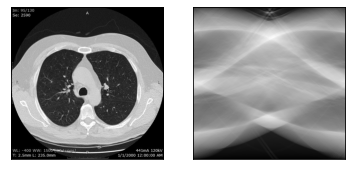

In [6]:
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

print(cv)

def discrete_radon_transform(image, steps):
    R = np.zeros((steps, len(image)), dtype='float64')
    for s in range(steps):
        rotation = misc.imrotate(image, -s*180/steps).astype('float64')
        R[:,s] = sum(rotation)
    return R

# Read image as 64bit float gray scale
#image = misc.imread('slice.png', flatten=True).astype('float64')
image = cv.imread('/content/slice2.png', 0).astype('float64')
radon = discrete_radon_transform(image, 512)

# Plot the original and the radon transformed image
plt.subplot(1, 2, 1), plt.imshow(image, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.subplot(1, 2, 2), plt.imshow(radon, cmap='gray')
plt.xticks([]), plt.yticks([])
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Image dtype is not float. By default radon will assume you want to preserve the range of your image (preserve_range=True). In scikit-image 0.18 this behavior will change to preserve_range=False. To avoid this warning, explicitly specify the preserve_range parameter.
/usr/local/lib/python3.6/dist-packages/skimage/transform/radon_transform.py:91: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Image dtype is not float. By default radon will assume you want t

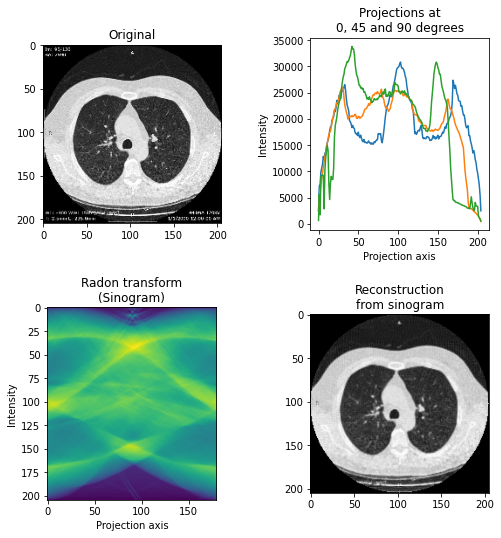

In [10]:
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.io import imread
from skimage.transform import radon, iradon
from scipy.ndimage import zoom

def rad(img):

    image = zoom(img, 0.4)

    plt.figure(figsize=(8, 8.5))

    plt.subplot(221)
    plt.title("Original");
    plt.imshow(image, cmap=plt.cm.Greys_r)

    plt.subplot(222)
    projections = radon(image, theta=[0, 45, 90])
    plt.plot(projections);
    plt.title("Projections at\n0, 45 and 90 degrees")
    plt.xlabel("Projection axis");
    plt.ylabel("Intensity");

    projections = radon(image)
    plt.subplot(223)
    plt.title("Radon transform\n(Sinogram)");
    plt.xlabel("Projection axis");
    plt.ylabel("Intensity");
    plt.imshow(projections)

    reconstruction = iradon(projections)
    plt.subplot(224)
    plt.title("Reconstruction\nfrom sinogram")
    plt.imshow(reconstruction, cmap=plt.cm.Greys_r)

    plt.subplots_adjust(hspace=0.4, wspace=0.5)
    plt.show()


im = cv.imread('/content/slice2.png', 0)

rad(im)

In [11]:
pip install pydicom

     |████████████████████████████████| 35.5MB 27.2MB/s 


In [ ]:
def load_scan(path):

    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices


def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)